In [2]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

data_root = project_root / "data"
data_root.mkdir(parents=True, exist_ok=True)

In [4]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import numpy as np

In [5]:
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed

set_seed()

from utils.utils import save_model

from models.resnet50 import load_model_resnet50, init_model_resnet50

# Merics
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# # Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import create_unlearning_dataloader
from methods.influence.influence_utils import iterative_influence_unlearn
from methods.fisher.fisher_utils_v2 import fisher_unlearn

Device used: cuda


In [6]:

BATCH_SIZE = 64

EPS = 1000
MAX_NORM = 10  # 0.5
CG_ITERS = 5
SCALE = 1e3

In [7]:
naive_results_path = Path("D:/Unlearning/results/cifar10/naive")
results_path = Path("D:/Unlearning/results/cifar10/fisher")

model_file = naive_results_path / "ResNet50_CIFAR10_model.pth"
samples_to_unlearn_file = (
    naive_results_path / "cifar10_samples_to_unlearn_30per.json"
)
remaining_dataset_file = (
    naive_results_path / "updated_cifar10_data_splits.json"
)

In [8]:
original_model, original_model_name, criterion, _optimizer, transform = (
    load_model_resnet50(model_pth_path=model_file)
)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = "fisher_" + original_model_name

Load model...
Init model...
Done initializing model.
Model ID: 2398354323344, Optimizer ID: 2398355127984, Criterion ID: 2398355128128
Done loading model.


In [9]:
test_dataset = datasets.CIFAR10(
    root=data_root, train=False, transform=transform, download=True
)

In [10]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [11]:
model, *_ = init_model_resnet50()

Init model...
Done initializing model.
Model ID: 2396877648416, Optimizer ID: 2398355235232, Criterion ID: 2398355235328


In [12]:
model_path = results_path / f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader, results_path=results_path)

Loading and testing model: fisher_ResNet50_CIFAR10


Evaluating model: D:\Unlearning\results\cifar10\fisher\fisher_ResNet50_CIFAR10_model.pth: 100%|██████████| 157/157 [00:34<00:00,  4.53it/s]

Predictions and labels saved to fisher_ResNet50_CIFAR10_predictions.json


Metrics for fisher_ResNet50_CIFAR10:
  - Test Accuracy: 0.2016
  - Precision: 0.4265
  - Recall: 0.2016
  - F1 Score: 0.1179


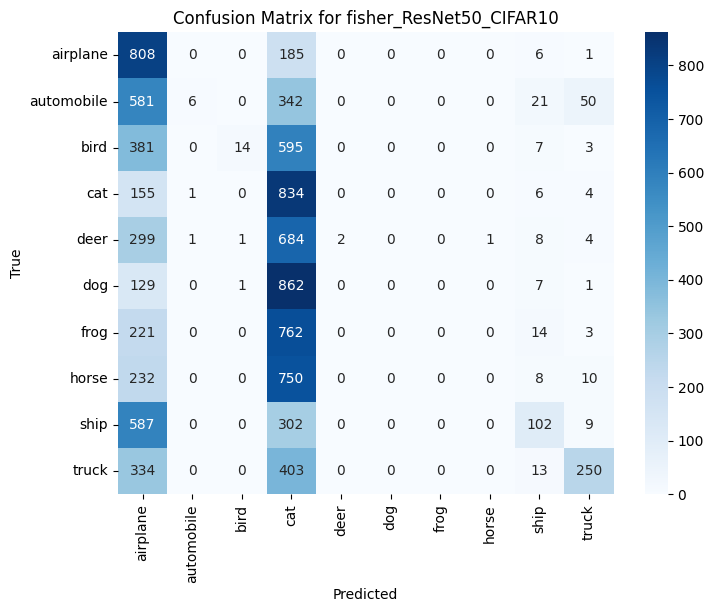

In [13]:
predictions_path = results_path / f"{model_to_unlearn_name}_predictions.json"
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)